# CO Freezeout 
Script to calculate the freeze-out from C18O 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.wcs import WCS
from radio_beam import Beam
from astropy.constants import h, k_B, c

In [2]:
file_msd = './data/msd_reprojected.fits'
hdu_msd = fits.open(file_msd)[0]

hdu_c180 = fits.open('./data/c18o_mom0_reprojected.fits')[0]

# Smooth mass surface density map

In [3]:
def smooth_hdu(hdu, target_fwhm=7.7*u.arcsec, original_fwhm=2*u.arcsec):
    """
    Smooth an HDU image from an original beam (e.g., 2″) to a target beam (e.g., 7.7″).

    Parameters
    ----------
    hdu : astropy.io.fits.HDU
        The input FITS HDU containing the image data and header.
    target_fwhm : astropy.units.Quantity, optional
        The desired (target) FWHM of the beam (default is 7.7 arcsec).
    original_fwhm : astropy.units.Quantity, optional
        The original FWHM of the beam (default is 2 arcsec).

    Returns
    -------
    new_hdu : astropy.io.fits.PrimaryHDU
        A new HDU with the smoothed image.
    
    Notes
    -----
    This function uses radio_beam to compute the convolution kernel beam such that
    convolving the original beam with the kernel yields the target beam. The kernel is then
    converted to pixel units using the image’s pixel scale from the WCS. If WCS information
    is missing, a fallback pixel scale of 2 arcsec/pixel is assumed.
    """
    
    # Try to extract the pixel scale from the WCS; assume square pixels.
    try:
        w = WCS(hdu.header)
        print('Taking pixel scale from WCS')
        # Assume CDELT1 (in degrees) is present; convert to arcsec.
        pixel_scale = np.abs(w.wcs.cdelt[0]) * 3600.0 * u.arcsec
    except Exception:
        print('Could not extract pixel scale from WCS; assuming 2 arcsec/pixel')
        # Fallback: assume 2 arcsec per pixel.
        pixel_scale = 2 * u.arcsec

    # Define the original and target beams using radio_beam.
    orig_beam = Beam(major=original_fwhm, minor=original_fwhm, pa=0*u.deg)
    target_beam = Beam(major=target_fwhm, minor=target_fwhm, pa=0*u.deg)
    
    # Compute the convolution kernel beam by deconvolving the original beam from the target beam.
    kernel_beam = target_beam.deconvolve(orig_beam)
    kernel_fwhm = kernel_beam.major  # FWHM of the kernel beam (assumed circular here)

    # Convert the kernel FWHM from arcsec to pixels.
    kernel_fwhm_pixels = (kernel_fwhm / pixel_scale).decompose().value
    
    # For a Gaussian, sigma = FWHM / (2*sqrt(2*ln2)) ≈ FWHM / 2.3548.
    sigma_pixels = kernel_fwhm_pixels / 2.3548

    # Create a 2D Gaussian kernel.
    gauss_kernel = Gaussian2DKernel(sigma_pixels)

    # Convolve the image data with the kernel.
    smoothed_data = convolve_fft(hdu.data, gauss_kernel, preserve_nan=True)
    
    # Create a new HDU with the smoothed data.
    hdu.header['BMAJ'] = target_fwhm.to(u.deg).value
    hdu.header['BMIN'] = target_fwhm.to(u.deg).value
    hdu.header['BPA'] = 0.0
    new_hdu = fits.PrimaryHDU(data=smoothed_data, header=hdu.header)
    return new_hdu

target_fwhm = 7.731782495587368*u.arcsec # GBT data resolution
original_fwhm = 2*u.arcsec #from 8 μm SMF mass surface density, ΣSMF, map KT10
hdu_msd_smoothed = smooth_hdu(hdu_msd, target_fwhm=target_fwhm, original_fwhm=original_fwhm)
hdu_msd_smoothed.writeto('./data/msd_reprojected_smoothed.fits', overwrite=True)

Taking pixel scale from WCS


# Define column density 

In [4]:
def compute_g_j(j):
    """g-factors from quantum numbers"""
    return (2 * j) + 1

def compute_wavelength(freq):
    """Wavelength (m) from the frequency (Hz)"""
    return (c / freq).to(u.cm)

def compute_E_j(j, B):
    """Energy of the energy of level (J)"""
    return j * (j + 1) * h * B

def _compute_Q_rot(j, E_j, T_ex):
    """Compute the partition function for a molecule given the excitation temperature and rotational constant."""
    return (2 * j + 1) * np.exp((-E_j / (k_B * T_ex)).decompose().value)

def compute_partition_function(T_ex, B, maxJ=10):
    """
    Compute the partition function for a molecule given the excitation
    temperature and rotational constant.
    """
    Q_rot = 0.0
    for j in range(maxJ):
        E_j = compute_E_j(j, B)
        Q_rot += _compute_Q_rot(j, E_j, T_ex)
    return Q_rot

def compute_J_T(T, freq):
    """equivalent Rayleigh-Jeans temperatures"""
    return (h * freq / k_B) / (np.exp((h * freq / (k_B * T)).decompose().value) - 1.0)

def compute_column_density(I, eI, T_ex, T_bg,
                           freq, A, B, q_l, q_u, maxJ=10):
    """
    Compute the column density and its error for a molecular transition,
    given its integrated intensity (in K km/s) and associated error.

    Parameters
    ----------
    I : astropy.units.Quantity
        Integrated intensity in K km/s.
    eI : astropy.units.Quantity
        Uncertainty in the integrated intensity (same units as I).
    T_ex : float
        Excitation temperature in K.
    T_bg : float
        Background temperature in K.
    freq : astropy.units.Quantity
        Transition frequency (e.g., in Hz).
    A : float
        Einstein A coefficient (s^-1).
    B : astropy.units.Quantity
        Rotational constant (in Hz).
    l : float
        Lower rotational quantum number.
    u : float
        Upper rotational quantum number.
    maxJ : int, optional
        Maximum quantum number used in the partition function sum (default=10).
        
    Returns
    -------
    N : astropy.units.Quantity
        Column density in cm^-2.
    eN : astropy.units.Quantity
        Uncertainty in the column density in cm^-2.
    """
    # -----------------------------
    # Fundamental constants and derived quantities
    # -----------------------------
    # g-factors from quantum numbers
    g_l = compute_g_j(q_l)
    g_u = compute_g_j(q_u)

    # Wavelength (m) from the frequency (Hz)
    wavelength = compute_wavelength(freq) # c in m/s, freq in Hz → wavelength in m
    print('Wavelength', wavelength)
    print('hv/k', (h * freq / k_B).to('K'))

    # Energy of the lower level (J)
    E_l = compute_E_j(q_l, B)
    print('E_l', E_l)

    # -----------------------------
    # Partition function: Q_rot = sum_{j=0}^{maxJ-1} (2j+1) exp[-E_j/(k_B T_ex)]
    # where E_j = j(j+1) h B.
    # -----------------------------
    Q_rot = compute_partition_function(T_ex, B, maxJ=maxJ)
    print('Q_rot', Q_rot)
    
    # -----------------------------
    # Brightness temperature correction:
    # J(T) = (h*nu/k_B) / (exp(h*nu/(k_B*T)) - 1)
    # -----------------------------
    # Note: we use .decompose().value to work with dimensionless arguments inside np.exp.
    J_ex = compute_J_T(T_ex, freq)
    J_bg = compute_J_T(T_bg, freq)
    print('J_ex', J_ex)
    print('J_bg', J_bg)
    
    # -----------------------------
    # Compute the prefactor (fcol) in the column density equation:
    #
    # N = fcol * (integrated intensity)    where:
    #
    #   fcol = (8π/(λ^3 A)) * (g_l/g_u) * 1/(J_ex - J_bg) *
    #          1/(1 - exp(-h*freq/(k_B*T_ex))) * Q_rot *
    #          1/(g_l * exp(-E_l/(k_B*T_ex)))
    # -----------------------------
    top_factor      = (8 * np.pi) / (wavelength**3 * A)
    factor_degen    = g_l / g_u
    factor_J        = 1.0 / (J_ex - J_bg)
    factor_exp_term = 1.0 / (1.0 - np.exp((-h * freq / (k_B * T_ex)).decompose().value))
    factor_level    = Q_rot / (g_l * np.exp((-E_l / (k_B * T_ex)).decompose().value))
    
    fcol = top_factor * factor_degen * factor_J * factor_exp_term * factor_level
    
    # -----------------------------
    # Compute the column density (N) in cm^-2.
    # -----------------------------
    N_val = I *  fcol
    N_err = eI * fcol

    # Likely the units come out as m^-2; convert to cm^-2.
    N = N_val.to(u.cm**-2)
    N_err = N_err.to(u.cm**-2)
    
    return N, N_err

# Get Column density for C18O

In [5]:
# ------------------------------------------------------------------------------
# Example usage for C18O (1–0)
# ------------------------------------------------------------------------------

I_c18o  = hdu_c180.data * u.K * u.km / u.s   # example integrated intensity
eI_c18o = hdu_c180.data * u.K * u.km / u.s   # example uncertainty
T_ex    = 7.5 *u.K                    # excitation temperature in K (typical for CO)
T_bg    = 2.72548 *u.K               # background (CMB) temperature in K

# Constants for C18O (1–0)
freq_c18o = 109.7821734e9 * u.Hz   # frequency in Hz 
A_c18o    = 6.266e-8 / u.s         # Einstein A coefficient in s^-1 
B_c18o    = 54.89142e9 * u.Hz      # Rotational constant in Hz
l_c18o    = 0.0                  # lower level quantum number (J = 0)
u_c18o    = 1.0                  # upper level quantum number (J = 1)

N_c18o, eN_c18o = compute_column_density(I_c18o, eI_c18o,
                                         T_ex, T_bg,
                                         freq_c18o, A_c18o, B_c18o,
                                         l_c18o, u_c18o, maxJ=10)

# Just for testing... 
# N_c18o_, eN_c18o_ = compute_column_density(1*u.K*u.km/u.s, 1*u.K*u.km/u.s,
#                                          T_ex, T_bg,
#                                          freq_c18o, A_c18o, B_c18o,
#                                          l_c18o, u_c18o, maxJ=10)

# print(f"\n   C18O (1–0) column density: {N_c18o_.value:.2e} 1/cm^2")

Wavelength 0.2730793613528515 cm
hv/k 5.268713352690394 K
E_l 0.0 Hz J s
Q_rot 3.2054533168060106
J_ex 5.171572992228938 Hz K s
J_bg 0.8913217569486075 Hz K s


In [6]:
import astropy.units as u
import astropy.constants as const

def compute_fd(N_c18o, hdu_msd_smoothed, Xco=1.4e-4, O_ratio=372, m_mu=2.8):
    """
    Calculate the depletion factor (fd) based on the column densities.
    
    Parameters:
        N_c18o : astropy.Quantity
            Column density of C18O (e.g., in cm^-2)
        hdu_msd_smoothed : astropy.io.fits.PrimaryHDU
            Smoothed mass surface density FITS HDU
        Xco : float, optional
            CO abundance ratio (default: 1.4e-4)
        O_ratio : float, optional
            Oxygen isotope ratio (default: 372)
        m_mu : float, optional
            Mean molecular weight per hydrogen molecule (default: 2.8)
    
    Returns:
        fd : astropy.Quantity
            Depletion factor (dimensionless)
    """
    # Compute H2 column density from C18O column density
    N_h2_c18o = N_c18o / (Xco / O_ratio)
    
    # Convert smoothed mass surface density to H2 column density
    data_msd_smoothed = hdu_msd_smoothed.data * u.g * u.cm**-2
    N_h2_msd = data_msd_smoothed / (const.m_p * m_mu)
    
    # Compute depletion factor
    fd = N_h2_msd.to(u.cm**-2) / N_h2_c18o.to(u.cm**-2)
    
    return fd, N_h2_c18o, N_h2_msd

fd, N_h2_c18o, N_h2_msd = compute_fd(N_c18o, hdu_msd_smoothed)
hdu_fd = fits.PrimaryHDU(data=fd.value, header=hdu_msd_smoothed.header)
hdu_fd.writeto('./data/fd.fits', overwrite=True)

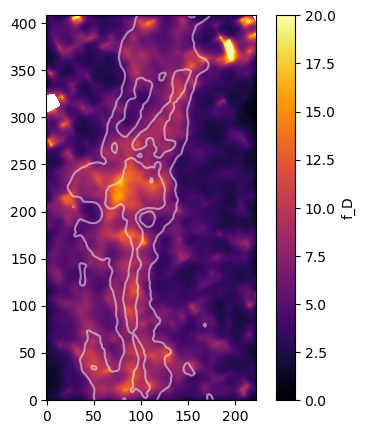

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
im = ax.imshow(hdu_fd.data, cmap='inferno', origin='lower', vmin=0, vmax=20)
ax.contour(hdu_msd.data, levels=[0.1,0.2], colors='white', alpha=0.5)
cbar = plt.colorbar(im)
cbar.set_label('f_D')

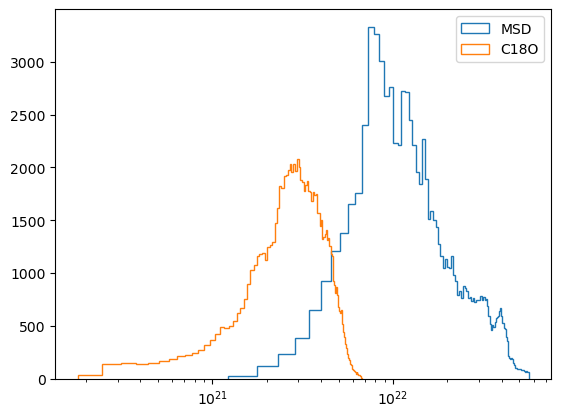

In [8]:
plt.hist(N_h2_msd.to(u.cm**-2).value.flatten(), bins=100, histtype='step', label='MSD')
plt.hist(N_h2_c18o.to(u.cm**-2).value.flatten(), bins=100, histtype='step', label='C18O')
plt.xscale('log')
plt.legend()

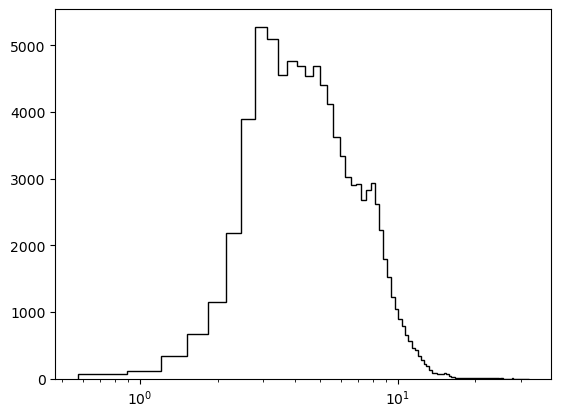

In [9]:
plt.hist(fd.value.flatten(), bins=100, histtype='step', color='k')
plt.xscale('log')